<a href="https://colab.research.google.com/github/davidkubanek/Thesis/blob/main/concerto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONCERTO architecture

In [ ]:
# for running in colab
!pip install dgl
!pip install rdkit
!pip install torch_geometric
!pip install wandb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
plt.rcParams["font.family"] = "Palatino"

import dgl
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader import DataLoader
#import wandb
import warnings

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

## Carci + Mut CONCERTO data
Load in the carcinogenecity and mutagenecity data as in CONCERTO paper.

In [ ]:
class CancerMutDatasetClass(Dataset):
	'''
	Imports and pre-processes the Cancer and Mutagenecity data and returns them in the form of a dataset
	'''
	def __init__(self, out_feats=1, drop_ionic=True, min_carbon_count=0, fraction_of_data=1, use_carc_prob=False, carc_percentile_to_drop=0):
		self.out_feats = out_feats
		self.drop_ionic = drop_ionic
		self.min_carbon_count = min_carbon_count
		self.fraction_of_data = fraction_of_data
		self.use_carc_prob = use_carc_prob
		self.carc_percentile_to_drop = carc_percentile_to_drop

	def load_carc_cpdb(cls):
		cpdb = pd.read_csv(
			'Data/concerto data/cpdb_aggergated.csv',
			usecols=['smiles', 'td50_log_harmonic', 'cas', 'carc_class', 'carc_class_multi']
		)
		cpdb['smiles'] = cls.smiles_standardize(cpdb['smiles'].values)
		cpdb = cpdb[cpdb['smiles'].notnull()]
		cpdb.rename(columns={'td50_log_harmonic': 'td50'}, inplace=True)
		assert cpdb['smiles'].duplicated().sum() == 0, \
			cpdb[cpdb['smiles'].duplicated(keep=False)].sort_values('smiles').to_string()
		cpdb['source'] = 'cpdb'
		return cpdb

	def load_mut_hansen(cls):
		ames_df = pd.read_csv('Data/concerto data/hansen_2009_ames.smi', sep='\t', names=['smiles', 'cas', 'class'])
		ames_df['smiles'] = cls.smiles_standardize(ames_df['smiles'].values)
		ames_df = ames_df[ames_df['smiles'].notnull()]
		ames_df.rename(columns={'class': 'mut_class'}, inplace=True)
		ames_df.drop(columns='cas', inplace=True)
		ames_df = ames_df[~ames_df.duplicated(['smiles', 'mut_class'])]
		assert ames_df['smiles'].duplicated().sum() == 0, \
			ames_df[ames_df['smiles'].duplicated(keep=False)].sort_values('smiles').to_string()
		ames_df['source'] = 'hansen'
		return ames_df


	def smiles_standardize(cls, smiles):
		new_smiles = []
		for smile in smiles:
			if pd.isnull(smile):
				new_smiles.append(None)
				continue
			# Generate the molecule from smile string
			mol = Chem.MolFromSmiles(smile)
			# If the smile string is null then continue
			if pd.isnull(mol):
				new_smiles.append(None)
			else:
				new_smiles.append(Chem.MolToSmiles(mol,canonical=True,isomericSmiles=False,allBondsExplicit=False))
		return new_smiles

	def count_num_carbons(cls, smile):
		mol = Chem.MolFromSmiles(smile)
		num_c = 0
		for atom in mol.GetAtoms():
			if atom.GetSymbol().upper() == 'C':
				num_c += 1
		return num_c

	def load_data(self):
		# Loaded data should not overlap mut_hansn and carc_cpdb since they are the two primary training data sources
		mut = self.load_mut_hansen()
		carc = self.load_carc_cpdb()

		carc_datasets = []
		mut_datasets = []

		carc_datasets.append(carc)

		# if 'carc_ccris' in self.carc_datasets:
		# 	temp = self.load_carc_ccris()
		# 	# drop samples that are in training data by default cpdb & carc_pred_el
		# 	temp = temp[~temp['smiles'].isin(carc['smiles'])]
		# 	carc_datasets.append(temp)

		mut_datasets.append(mut)

		if mut_datasets:
			mut = pd.concat(mut_datasets)
		else:
			mut = pd.DataFrame(columns=mut.columns)

		if carc_datasets:
			carc = pd.concat(carc_datasets)
		else:
			carc = pd.DataFrame(columns=carc.columns)

		# check for duplicates
		if mut['smiles'].duplicated().sum() != 0:
			warnings.warn(f"duplicated samples {mut['smiles'].duplicated().sum()} contained in mutagenicity data "
						  f"from {mut_datasets}\n"
						  f" {mut[mut['smiles'].duplicated(keep=False)].sort_values('smiles').head().to_string()}")
			mut.sort_values(['smiles', 'mut_class'], ascending=False)
			mut = mut[~mut.duplicated('smiles')]

		if carc['smiles'].duplicated().sum() != 0:
			warnings.warn(f"duplicated samples {carc['smiles'].duplicated().sum()} contained in carcinogenicity data "
						  f"from {carc_datasets}\n"
						  f" {carc[carc['smiles'].duplicated(keep=False)].sort_values('smiles').head().to_string()}")
			carc = carc[~carc.duplicated('smiles')]

		# merge the mut and carc datasets
		df = pd.merge(mut, carc, how='outer', on='smiles')
		df['source'] = df['source_x'].fillna('') + ',' + df['source_y'].fillna('')
		df.drop(columns=['source_x', 'source_y'], inplace=True)

		required_columns = ['td50', 'carc_class', 'mut_class', 'carc_class_multi']
		for column in required_columns:
			if column not in df.columns:
				df[column] = np.nan

		if self.drop_ionic:
			df = df[~df['smiles'].str.contains('\.')]

		df['carbon_count'] = [self.count_num_carbons(x) for x in df['smiles'].values]
		if self.min_carbon_count:
			df = df[df['carbon_count'] >= self.min_carbon_count]

		# Shuffle the data
		index = np.arange(len(df))
		np.random.seed(1337)
		np.random.shuffle(index)
		df = df.iloc[index].reset_index(drop=True)

		# Log of Betas that were fitted using a cox regression model
		if self.carc_percentile_to_drop > 0:
			# cleave off the top percentile
			lowest_td_50_val = np.nanpercentile(df['td50'].values, self.carc_percentile_to_drop)
			mask = df[df['td50'] <= lowest_td_50_val].index
			df.loc[mask, 'td50'] = lowest_td_50_val

		betas = np.log((np.log(2) / df["td50"].values))

		# standardize
		beta_standardized = (betas - np.nanmean(betas)) / np.nanstd(betas)
		# normalize
		beta_normalized = betas - np.nanmin(betas)
		beta_normalized = beta_normalized / np.nanmax(beta_normalized)

		df['beta_standardized'] = beta_standardized
		df['beta_normalized'] = beta_normalized

		if self.fraction_of_data < 1:
			new_data_len = int(len(df) * self.fraction_of_data)
			df = df.iloc[:new_data_len]

		#save the resulting dataframe
		self.df = df


In [ ]:
dataset = CancerMutDatasetClass()
dataset.load_data()

In [ ]:
# give random draw of data
dataset.df.sample(10)

,smiles,mut_class,cas,td50,carc_class_multi,carc_class,source,carbon_count,beta_standardized,beta_normalized
1633,CC(C)(C)c1ccc(OP2OCC3(CO2)COP(Oc2ccc(C(C)(C)C)...,0.0,NaN,NaN,NaN,NaN,"hansen,",33,NaN,NaN
4820,Nc1ccc(CO)c([N+](=O)[O-])c1,1.0,NaN,NaN,NaN,NaN,"hansen,",7,NaN,NaN
6547,NCCNCCNCCN,1.0,NaN,NaN,NaN,NaN,"hansen,",6,NaN,NaN
1001,BrCc1c2ccccc2c2ccc3cccc4ccc1c2c43,1.0,NaN,NaN,NaN,NaN,"hansen,",21,NaN,NaN
545,OC1C=Cc2ncccc2C1O,0.0,NaN,NaN,NaN,NaN,"hansen,",9,NaN,NaN
4971,COC(C(=O)O)c1ccccc1,NaN,1701-77-5,6.598778,2.0,1.0,",cpdb",9,-0.085314,0.175281
1094,CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C,0.0,NaN,NaN,NaN,NaN,"hansen,",23,NaN,NaN
1664,CC(=O)Nc1nc2c3cccnc3ccc2n1C,1.0,NaN,NaN,NaN,NaN,"hansen,",13,NaN,NaN
5062,O=[N+]([O-])c1ccc2c3ccccc3c3cccc4ccc1c2c43,1.0,NaN,NaN,NaN,NaN,"hansen,",20,NaN,NaN
1571,CN(C)c1nc(N(C)C)nc(N(C)C)n1,0.0,NaN,NaN,NaN,NaN,"hansen,",9,NaN,NaN


In [ ]:
'''
Some things from the original code that I might need to use later
'''
# Clip loss
# torch.nn.utils.clip_grad_norm_(model.parameters(), args["gradient_clip_norm"])
# optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['network_weight_decay'])
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=args['lr_decay_factor'])

# early_stop = stopper.step(val_score, model)
# if args["use_wandb"]:
#     wandb.log({
#         f"epoch{note}": epoch + 1,
#         f"training_carcinogenic_loss{note}": train_carc_loss,
#         f"training_mutagenic_loss{note}": train_mut_loss,
#         f"training_loss{note}": train_loss,
#         f"training_mut_{train_mut_metric_name}{note}": train_mut_metric,
#         f"training_mut_{train_mut_metric_name2}{note}": train_mut_metric2,
#         f"training_carc_{train_carc_metric_name}{note}": train_carc_metric,
#         f"training_carc_{train_carc_metric_name2}{note}": train_carc_metric2,

#         f"validation_loss{note}": val_loss,
#         f"validation_carc_loss{note}": val_carc_loss,
#         f"validation_mut_loss{note}": val_mut_loss,
#         f"validation_carc_{val_carc_metric_name}{note}": val_carc_metric,
#         f"validation_carc_{val_carc_metric_name2}{note}": val_carc_metric2,
#         f"validation_mut_{val_mut_metric_name}{note}": val_mut_metric,
#         f"validation_mut_{val_mut_metric_name2}{note}": val_mut_metric2,
#     })

# if early_stop:
#     break
# stopper.load_checkpoint(model)


## HTSFP PubChem data
Load in the HTSFP data from the activity matrix generated in 'HTS_fingerprints'

In [4]:
# Load the matrix
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/'
else:
    directory = 'Data/'

matrix_df = pd.read_csv(directory+'activity_matrix_100.csv') #Thesis/Data
matrix_df.head()

,SMILES,1347041,652048,652051,1259415,624414,623870,624415,652067,652126,...,588405,588458,588489,588492,588493,588621,588850,602141,588352,588664
0,CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...,-38.089760,-0.854682,-0.854682,0.000000,2.996274,-0.000844,-0.370409,0.000000,0.000000,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.260380,-0.372029
1,C1CN(C(C2=C1C3=CC=CC=C3N2)C4=CC(=CC=C4)O)CC5=C...,-19.754667,-0.054001,-0.054001,0.460832,0.190177,0.141050,0.024654,1.223655,1.856588,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.500548,0.058574
2,CN(C)C1=CC2=C(C=C1)C=C3C=CC(=[N+](C)C)C=C3O2.[...,-19.184208,-0.411341,-0.411341,-1.302143,3.293683,0.897816,-0.629843,-0.924189,-0.475099,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,-0.002158,-1.399202
3,CCN=C(N/N=C/C1=CC=C(C=C1)[N+](=O)[O-])SC.I,-17.771549,-0.728801,-0.728801,0.000339,-0.240306,-0.048142,-0.277951,-0.316357,-0.264545,...,-0.06599,-0.045673,-0.030214,NaN,-0.038655,-0.024894,-0.046669,-0.030226,0.265324,0.124896
4,CS(=O)(=O)C1=NSC2=NC(=O)/C(=C\C3=CC=CN3C4=CC=C...,-17.696121,-0.566208,-0.566208,-0.134861,-0.087835,0.093752,0.262823,-0.520670,0.000596,...,-0.06599,-0.045673,-0.030214,NaN,6.467426,10.042401,-0.046669,-0.030226,0.421434,-0.018203


In [ ]:
# find assays which are have only positive or only negative values
def data_explore(matrix_df):
    '''
    Explore the data
    '''
    # replace null values with 0
    matrix_df.fillna(0, inplace=True)
    # check proportion of positive and negative samples across each assay
    pos = np.sum(matrix_df.values, axis=0)
    print(f'Proportion of positive samples in each assay: {np.round(pos/len(matrix_df),2)}')


    # check proportion of positive and negative samples across each assay
    pos = np.sum(y, axis=0)
    print(f'Proportion of positive samples in each assay: {np.round(pos/len(y),2)}')




In [38]:
# replace null values with 0
matrix_df.fillna(0, inplace=True)

# check if there is any assay that has zero values across all compounds
pos_assays = torch.ones(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    
    if matrix_df[assay].any() != 0:
        pos_assays[i-1] = 0
    
# check if there is any compound that has zero values across all assays
pos_compounds = torch.ones(len(matrix_df))
for i, compound in enumerate(matrix_df['SMILES']):
    # print(matrix_df.iloc[i,1:])
    if matrix_df.iloc[i,1:].any() != 0:
        pos_compounds[i] = 0

# check proportion of positive and negative samples across each assay
pos_ratio = torch.zeros(len(matrix_df.columns)-1)
for i, assay in enumerate(matrix_df.columns):
    # print(matrix_df[assay])
    if assay=='SMILES':
        continue
    # first make column binary
    y = np.where(matrix_df[assay].values>0, 1, 0)
    pos_ratio[i-1] = y.sum()/len(y)


TypeError: where() received an invalid combination of arguments - got (numpy.ndarray, int, int), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !int!, !int!)


In [55]:
print('Assays without activity: ', matrix_df.columns[1:][np.where(pos_assays.int().numpy()==1)])
if pos_compounds.sum() > 0:
    print('Compounds without activity: ', matrix_df['SMILES'][np.where(pos_compounds.int().numpy()==1)])
else:
    print('Compounds without activity: All compounds have activity')



Assays without activity:  Index(['651725', '588492'], dtype='object')
Compounds without activity: All compounds have activity


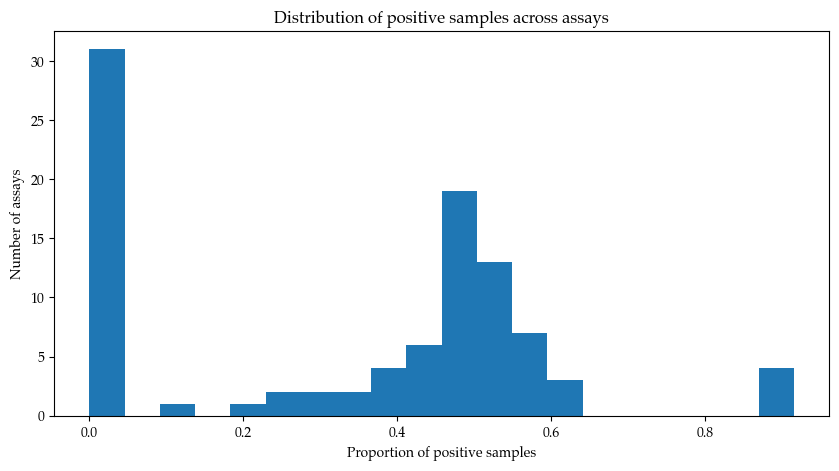

In [45]:
#plot pos_ratio
plt.figure(figsize=(10,5))
plt.hist(pos_ratio, bins=20)
plt.xlabel('Proportion of positive samples')
plt.ylabel('Number of assays')
plt.title('Distribution of positive samples across assays')
plt.show()

In [53]:
print('Assays with few positive samples: \n', matrix_df.columns[1:][torch.where(pos_ratio<0.2)].values)


Assays with few positive samples: 
 ['493056' '493084' '504660' '651725' '602429' '602438' '602440' '602449'
 '624168' '624204' '624304' '624352' '624354' '651560' '651636' '651699'
 '651999' '602244' '602261' '602274' '602399' '743279' '651647' '504651'
 '588405' '588458' '588489' '588492' '588493' '588621' '588850' '602141']


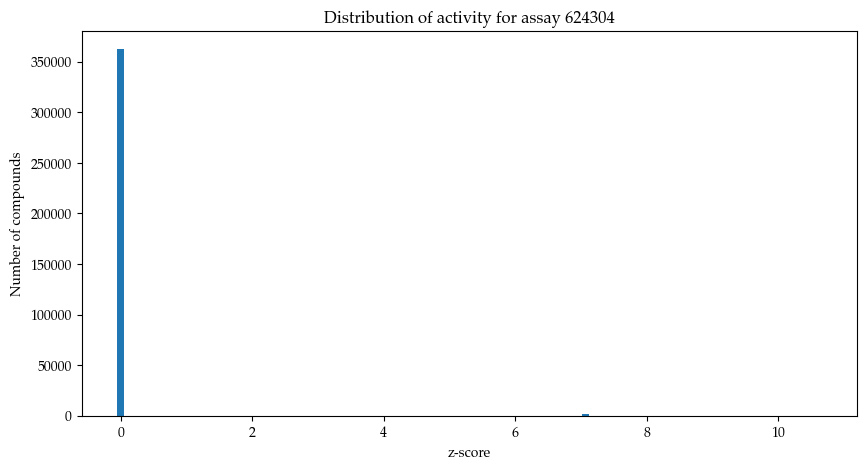

In [60]:
# show the distribution of values for any assay
assay = '624304'
plt.figure(figsize=(10,5))
plt.hist(matrix_df[assay], bins=100)
plt.xlabel('z-score')
plt.ylabel('Number of compounds')
plt.title('Distribution of activity for assay '+assay)
plt.show()

A number of assays have mainly positive z-scores or mainly negative z-scores.
It seems that all of those have many compoounds with low negative scores and very few with very high positive scores. This indicates that few compounds are strong outliers on one side and shift the mean such that almost all compounds get a negative z-score. The effect of one strong outlier washes out the distribution for all other compound -> is this a valid outlier or noise?

# Representation

## Fingerprints
smiles →  fingerprints

In [16]:
def convert_smile_to_fp_bit_string(smile):
        """
        Convert SMILES string to concatenation of RDFKIT, Morgan and MACCSS fingerprints.
        """
        # RDFKIT (fingerprint dim fpSize=1024)
        x = Chem.MolFromSmiles(smile)
        fp1 = Chem.RDKFingerprint(x, fpSize=1024)

        # MACCSS substructure (fingerprint dim 167)
        fp2 = MACCSkeys.GenMACCSKeys(x)

        # Morgan (fingerprint dim fpSize=1024)
        fp_hashes = []
        fp3 = AllChem.GetHashedMorganFingerprint(x, 2, nBits=1024)
        fp3_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp3, fp3_array)
        fp_hashes.append(fp3_array)

        # combine all fingerprints
        fp = fp1.ToBitString() + fp2.ToBitString()
        fp = np.array(list(fp)).astype(np.int8)
        fp = np.concatenate([fp] + fp_hashes)
        fp = torch.tensor(fp).to(torch.float32)
        return fp

Get sample fingerprint

SMILES: CN(CC(=O)NC1=CC=CC=C1Br)C(=O)C2=CC=C(O2)C3=CC=C(C=C3)Cl
Fingerprint: tensor([1., 1., 1.,  ..., 0., 0., 0.]) torch.Size([2215])
RDK Fingerprint:


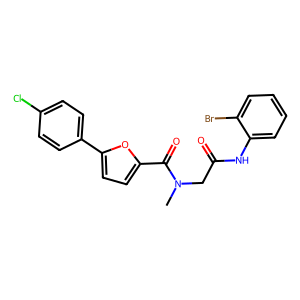

In [17]:
smile = matrix_df.sample(1)['SMILES'].item()
fp = convert_smile_to_fp_bit_string(smile)
print('SMILES:', smile)
print('Fingerprint:', fp, fp.shape)

x = Chem.MolFromSmiles(smile)
fp1 = Chem.RDKFingerprint(x, fpSize=1024)
fp1 = np.array(list(fp1.ToBitString())).astype(np.int8)
from rdkit.Chem import Draw
img = Draw.MolToImage(x)
print('RDK Fingerprint:')
img

## Graph embedding
smiles →  graph embedding

In [15]:
# smiles to graphs
import numpy as np

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader

class GraphDatasetClass:
    '''
    Convert a dataframe of SMILES into a Pytorch Geometric Graph Dataset.
    https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
    '''

    def __init__(self):
        pass

    def one_hot_encoding(self, x, permitted_list):
        """
        Maps input elements x which are not in the permitted list to the last element
        of the permitted list.
        """

        if x not in permitted_list:
            x = permitted_list[-1]

        binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

        return binary_encoding


    def get_atom_features(self, atom,
                        use_chirality = True,
                        hydrogens_implicit = True):
        """
        Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
        """

        # define list of permitted atoms

        permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

        if hydrogens_implicit == False:
            permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

        # compute atom features

        atom_type_enc = self.one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

        n_heavy_neighbors_enc = self.one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

        formal_charge_enc = self.one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

        hybridisation_type_enc = self.one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

        is_in_a_ring_enc = [int(atom.IsInRing())]

        is_aromatic_enc = [int(atom.GetIsAromatic())]

        atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

        vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

        covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

        atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

        if use_chirality == True:
            chirality_type_enc = self.one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
            atom_feature_vector += chirality_type_enc

        if hydrogens_implicit == True:
            n_hydrogens_enc = self.one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
            atom_feature_vector += n_hydrogens_enc

        return np.array(atom_feature_vector)

    def get_bond_features(self, bond,
                        use_stereochemistry = True):
        """
        Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
        """

        permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

        bond_type_enc = self.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

        bond_is_conj_enc = [int(bond.GetIsConjugated())]

        bond_is_in_ring_enc = [int(bond.IsInRing())]

        bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

        if use_stereochemistry == True:
            stereo_type_enc = self.one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
            bond_feature_vector += stereo_type_enc

        return np.array(bond_feature_vector)

    def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(self, x_smiles, y):
        """
        Inputs:

        x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
        y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)

        Outputs:

        data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning

        """

        data_list = []

        for (smiles, y_val) in zip(x_smiles, y):

            # convert SMILES to RDKit mol object
            mol = Chem.MolFromSmiles(smiles)

            # get feature dimensions
            n_nodes = mol.GetNumAtoms()
            n_edges = 2*mol.GetNumBonds()
            unrelated_smiles = "O=O"
            unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
            n_node_features = len(self.get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
            n_edge_features = len(self.get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

            # construct node feature matrix X of shape (n_nodes, n_node_features)
            X = np.zeros((n_nodes, n_node_features))

            for atom in mol.GetAtoms():
                X[atom.GetIdx(), :] = self.get_atom_features(atom)

            X = torch.tensor(X, dtype = torch.float)

            # construct edge index array E of shape (2, n_edges)
            (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
            torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
            torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
            E = torch.stack([torch_rows, torch_cols], dim = 0)

            # construct edge feature array EF of shape (n_edges, n_edge_features)
            EF = np.zeros((n_edges, n_edge_features))

            for (k, (i,j)) in enumerate(zip(rows, cols)):

                EF[k] = self.get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

            EF = torch.tensor(EF, dtype = torch.float)

            # construct label tensor
            y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)

            # construct Pytorch Geometric data object and append to data list
            data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

        return data_list

## GROVER: graph transformer  fingerprints
smiles → node/edge features using RDkit → to fingerprint embedding using GTransformer

In [24]:
# import fingerprint .np file
if torch.cuda.is_available():
    directory = '/content/drive/MyDrive/Thesis/Data/'
else:
    directory = 'Data/'

grover_fp = np.load(directory + 'fp_large.npz', allow_pickle=True)
print(grover_fp.keys())  # Display the keys or attributes in the file
# Access and examine the data as needed
assert len(matrix_df)==len(grover_fp['smiles']), 'SMILES mismatch'

Index(['smiles', 'fps'], dtype='object')


In [25]:
grover_fp['smiles']

0         CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...
1         C1CN(C(C2=C1C3=CC=CC=C3N2)C4=CC(=CC=C4)O)CC5=C...
2         CN(C)C1=CC2=C(C=C1)C=C3C=CC(=[N+](C)C)C=C3O2.[...
3                CCN=C(N/N=C/C1=CC=C(C=C1)[N+](=O)[O-])SC.I
4         CS(=O)(=O)C1=NSC2=NC(=O)/C(=C\C3=CC=CN3C4=CC=C...
                                ...                        
364285               CCN(CC)CCNC1=NC=NC2=C1N(C3=CC=CC=C32)C
364286    CO/N=C(\C1=CN=C(S1)N)/C(=O)N[C@H]2[C@@H]3N(C2=...
364287     CC1(CC2=C(CO1)C(=NC(=C2C#N)NC3CCCCC3)C4=CC=CO4)C
364288       CNC(=O)C1=C(SC2=C1CCC2)NC(=O)C3=NC4=CC=CC=C4S3
364289    C1=CC(=CC(=C1)[N+](=O)[O-])N=N/C(=C(/C2=CC=C(C...
Name: smiles, Length: 364290, dtype: object

In [27]:
grover_fp['fps'][0].shape[0]

5000

In [12]:
args = {}
args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data parameters
args['num_data_points'] = 1000 # number of data points to use
args['num_assays'] = 1 # number of assays to use (i.e., no. of output classes)
args['assay_start'] = 0 # which assay to start from
args['num_node_features'] = 79 # number of node features in graph representation
args['grover_fp_dim'] = grover_fp['fps'][0].shape[0] # dim of grover fingerprints
args['fp_dim'] = 2215 # dim of fingerprints


# training parameters
args['model'] = 'GCN' # 'GCN', 'GCN_FP', 'FP', 'GROVER', 'GROVER_FP'
args['pred_type'] = 'classification' # 'regression', 'classification'
args['num_layers'] = 5 # number of layers in MLP
args['hidden_channels'] = 64
args['dropout'] = 0.1
args['batch_size'] = 64
args['num_epochs'] = 100
args['lr'] = 0.01
#args['gradient_clip_norm'] = 1.0
#args['network_weight_decay'] = 0.0001
#args['lr_decay_factor'] = 0.5





In [36]:
from torch_geometric.loader import DataLoader

def prepare_dataset(matrix_df, args, grover_fp=None):
    '''
    Convert matrix dataframe to a dataloader with pytorch geometric graph data, fingerprints and labels.
    Inputs:
        matrix_df: dataframe of SMILES, assays and bioactivity labels
        args: arguments
    Outputs:
        dataloader: dictionary of dataloaders for train and test
    '''
    # only use subset of data (assays and data points)
    num_assays = args['num_assays']
    assay_start = args['assay_start']
    num_data_points = args['num_data_points']
    # get columns names (assays) of the matrix
    assays = matrix_df.columns.values[1:]
    # get target labels
    y = matrix_df[assays[assay_start:assay_start+num_assays]].values[:num_data_points]
    if args['pred_type'] == 'regression':
        y = y.astype(np.float32)
    else:
        # convert to binary for classification
        y = np.where(y > 0, 1, 0)
    # get SMILES strings
    data = matrix_df['SMILES'].values[:num_data_points]



    GraphDataset = GraphDatasetClass()
    # create pytorch geometric graph data list
    data_list = GraphDataset.create_pytorch_geometric_graph_data_list_from_smiles_and_labels(data, y)

    # add fingerprint data to each graph
    for i, smile in enumerate(data):
        fp = convert_smile_to_fp_bit_string(smile)
        data_list[i].fp = fp


    # add grover fingerprint to each graph
    if grover_fp is not None:
        for i, gfp in enumerate(grover_fp['fps'][:args['num_data_points']]):
          data_list[i].grover_fp = gfp


    # split into train and test
    train_dataset = data_list[:int(len(data)*0.8)]
    test_dataset = data_list[int(len(data)*0.8):]

    print(f'Number of training graphs: {len(train_dataset)}')
    print(f'Number of test graphs: {len(test_dataset)}')
    print(f'Example of a graph data object: {data_list[0]}')

    # create data loaders
    dataloader = {}
    dataloader['train'] = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
    dataloader['test'] = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False)

    return dataloader

def data_explore(data, y):
    '''
    Explore the data
    '''
    # check proportion of positive and negative samples across each assay
    pos = np.sum(y, axis=0)
    print(f'Proportion of positive samples in each assay: {np.round(pos/len(y),2)}')



In [37]:
dataloader = prepare_dataset(matrix_df, args, grover_fp=grover_fp)

Number of training graphs: 800
Number of test graphs: 200
Example of a graph data object: Data(x=[39, 79], edge_index=[2, 82], edge_attr=[82, 10], y=[1, 1], fp=[2215], grover_fp=[5000])


# Models
### GCN and GCN_FP
- GCN: graph embedding followed by a final classification layer
- GCN_FP: graph + fingerprints embedding followed by a final classification layer

In [38]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    '''
    Define a Graph Convolutional Network (GCN) model architecture.
    Can include 'graph' only or 'graph + fingerprints' embedding before final classification layer.
    '''
    def __init__(self, args):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        num_node_features = args['num_node_features']
        hidden_channels = args['hidden_channels']
        num_classes = args['num_assays']
        if args['model'] == 'GCN_FP':
            fp_dim = args['fp_dim']
        else:
            fp_dim = 0

        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels + fp_dim, num_classes)

    def forward(self, x, edge_index, batch, fp=None):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # if also using fingerprints
        if fp is not None:
            # reshape fp to batch_size x fp_dim
            fp = fp.reshape(x.shape[0], -1)
            # concatenate graph node embeddings with fingerprint
            # print('BEFORE CONCAT x:',x.shape, 'fp:', fp.shape)
            x = torch.cat([x, fp], dim=1)
            # print('AFTER CONCAT x:',x.shape)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)

        return x


### FP, GROVER and GROVER_FP

In [39]:

class LinearBlock(nn.Module):
	""" basic block in an MLP, with dropout and batch norm """

	def __init__(self, in_feats, out_feats, dropout=0.1):
		super(LinearBlock, self).__init__()
		self.linear = nn.Linear(in_feats, out_feats)
		self.bn = nn.BatchNorm1d(out_feats)
		self.dropout = nn.Dropout(dropout)

	def forward(self, x):
		# ReLU activation, batch norm, dropout on layer
		return self.bn(self.dropout(F.relu(self.linear(x))))

def construct_mlp(in_dim, out_dim, hidden_dim, hidden_layers, dropout=0.1):
	"""
	Constructs an MLP with specified dimensions.
		- total number of layers = hidden_layers + 1 (the + 1 is for the output linear)
		- no activation/batch norm/dropout on output layer
	"""

	assert hidden_layers >= 1, hidden_layers
	mlp_list = []
	mlp_list.append(LinearBlock(in_dim,hidden_dim,dropout=dropout))
	for i in range(hidden_layers-1):
		mlp_list.append(LinearBlock(hidden_dim,hidden_dim,dropout=dropout))

	# no activation/batch norm/dropout on output layer
	mlp_list.append(nn.Linear(hidden_dim,out_dim))
	mlp = nn.Sequential(*mlp_list)
	return mlp

class MLP(nn.Module):
	'''
	MLP with optional Grover fingerprints.
	Customizable number of layers, hidden dimensions, and dropout.
	'''
	def __init__(self, args):

		super(MLP, self).__init__()

		self.fp_dim = args['fp_dim'] # can be 0
		self.grover_fp_dim = args['grover_fp_dim'] # can be 0
		self.hidden_dim = args['hidden_channels']
		self.output_dim = args['num_assays']
		self.num_layers = args['num_layers']
		self.dropout = args['dropout']

		self.ff_layers = construct_mlp(
			self.fp_dim + self.grover_fp_dim,
			self.output_dim,
			self.hidden_dim,
			self.num_layers,
			self.dropout
		)

	def forward(self, data):

		fingerprints = data.fp
		# reshape fp to batch_size x fp_dim
		fingerprints = fingerprints.reshape(int(fingerprints.shape[0]/self.fp_dim), -1)

		if self.grover_fp_dim > 0: #grover and fp are concatenated
			grover_fp = data.grover_fp
			output = self.ff_layers(torch.cat([fingerprints, grover_fp], dim=1))
		else:	# only fp is used
			output = self.ff_layers(fingerprints)

		return output

In [40]:
model = MLP(args)
for data in dataloader['train']:  # Iterate in batches over the training dataset
        print(data.x.shape, data.y.shape, data.fp.shape)
        print('reshape:', data.fp.shape)
        out = model(data)  # Perform a single forward pass
        print(out.shape)
        # add dimension to y
        data.y = data.y.unsqueeze(1)
        print(data.y.shape)
        break

torch.Size([1645, 79]) torch.Size([64, 1]) torch.Size([141760])
reshape: torch.Size([141760])


TypeError: ignored

In [ ]:
args['model'] = 'GCN_FP'
model = GCN(args)
for data in dataloader['train']:  # Iterate in batches over the training dataset
        print(data.x.shape, data.y.shape, data.fp.shape)
        print('reshape:', data.fp.shape)
        out = model(data.x, data.edge_index, data.batch, fp=data.fp)  # Perform a single forward pass
        print(out.shape)
        # add dimension to y
        data.y = data.y.unsqueeze(1)
        print(data.y.shape)
        break

torch.Size([1758, 79]) torch.Size([64]) torch.Size([141760])
reshape: torch.Size([141760])
torch.Size([64, 1])
torch.Size([64, 1])


# Training

In [ ]:
class TrainManager:

    def __init__(self, dataloader, args, model=None, wandb=False):

        self.args = args
        self.num_assays = args['num_assays']
        self.num_node_features = args['num_node_features']
        self.hideen_channels = args['hidden_channels']

        if not model:
            # initialize model depending on model type
            if args['model'] == 'GCN':
                self.model = GCN(args)
            elif args['model'] == 'GCN_FP':
                self.model = GCN(args)

            self.model.to(args['device'])
        else:
            self.model = model

        self.dataloader = dataloader

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCEWithLogitsLoss()

        self.curr_epoch = 0

        # logging
        self.log_loss = []
        self.log_acc_train = []
        self.log_acc_test = []


    def train(self, epochs=100, log=False):
        '''
        Train the model for a given number of epochs.
        '''
        self.model.train()


        for epoch in range(epochs):

            cum_loss = 0

            for data in self.dataloader['train']:  # Iterate in batches over the training dataset.

                data = data.to(self.args['device'])


                if args['model'] == 'GCN':
                    out = self.model(data.x, data.edge_index, data.batch)
                elif args['model'] == 'GCN_FP':
                    out = self.model(data.x, data.edge_index, data.batch, fp=data.fp)

                data.y = data.y.unsqueeze(1)
                loss = self.criterion(out, data.y)  # Compute the loss.
                loss.backward()  # Derive gradients.
                self.optimizer.step()  # Update parameters based on gradients.
                self.optimizer.zero_grad()  # Clear gradients.
                cum_loss += loss.item()

            self.log_loss.append(cum_loss/len(self.dataloader['train']))

            if log:
                # evaluate
                acc_train = self.eval(self.dataloader['train'])
                acc_test = self.eval(self.dataloader['test'])

                self.log_acc_train.append(acc_train)
                self.log_acc_test.append(acc_test)


                if epoch % 10 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Train Acc: {acc_train:.4f}, Test Acc: {acc_test:.4f}')

            self.curr_epoch += 1

    def eval(self, loader):
        '''
        Evaluate the model on a given dataset (train/val/test).
        '''
        self.model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.

            data = data.to(self.args['device'])

            # run forward based on model type
            if args['model'] == 'GCN':
                    out = self.model(data.x, data.edge_index, data.batch)
            elif args['model'] == 'GCN_FP':
                out = self.model(data.x, data.edge_index, data.batch, fp=data.fp)

            # convert out to binary
            pred = torch.round(torch.sigmoid(out))
            data.y = data.y.unsqueeze(1)
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
            acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
        return acc



    def analyze(self):
        '''
        Plot the model performance.
        '''

        # plot side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.plot(self.log_loss)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Losses')

        ax2.plot(self.log_acc_train, label='train')
        ax2.plot(self.log_acc_test, label='test')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy')
        ax2.legend()
        plt.show()



    def save_model(self, folder, filename, save_weights=True, save_logs=True):
        print('saving experiment...')

        filename += f'_{self.curr_epoch}e'
        if save_weights:
            torch.save(self.model.state_dict(), os.path.join(folder, filename+'.pt'))

        #if save_logs:

    def load_model(self, folder, filename):
        print('loading model...')
        self.model.load_state_dict(torch.load(os.path.join(folder, filename+'.pt')))


# Experiments

In [ ]:
dataloader = prepare_dataset(matrix_df, args)
data_explore(data, y)

Number of training graphs: 800
Number of test graphs: 200
Example of a graph data object: Data(x=[39, 79], edge_index=[2, 82], edge_attr=[82, 10], y=[1, 3], fp=[2215])
Proportion of positive samples in each assay: [0.37 0.37 0.45]


In [ ]:
args['model'] = 'GCN'
exp = TrainManager(dataloader, args)
exp.train(epochs=200, log=True)

Epoch: 0, Loss: 0.6697, Train Acc: 0.6312, Test Acc: 0.6350
Epoch: 10, Loss: 0.5761, Train Acc: 0.6350, Test Acc: 0.6550
Epoch: 20, Loss: 0.5977, Train Acc: 0.6500, Test Acc: 0.6450
Epoch: 30, Loss: 0.6248, Train Acc: 0.6675, Test Acc: 0.6650
Epoch: 40, Loss: 0.6470, Train Acc: 0.6875, Test Acc: 0.6700
Epoch: 50, Loss: 0.4427, Train Acc: 0.6863, Test Acc: 0.6450
Epoch: 60, Loss: 0.6447, Train Acc: 0.7100, Test Acc: 0.6550
Epoch: 70, Loss: 0.5270, Train Acc: 0.6987, Test Acc: 0.6600
Epoch: 80, Loss: 0.3699, Train Acc: 0.7125, Test Acc: 0.6600
Epoch: 90, Loss: 0.6815, Train Acc: 0.7462, Test Acc: 0.6650
Epoch: 100, Loss: 0.5555, Train Acc: 0.7262, Test Acc: 0.6600
Epoch: 110, Loss: 0.6707, Train Acc: 0.7562, Test Acc: 0.6600
Epoch: 120, Loss: 0.6151, Train Acc: 0.7388, Test Acc: 0.6850
Epoch: 130, Loss: 0.4503, Train Acc: 0.7388, Test Acc: 0.6300
Epoch: 140, Loss: 0.5061, Train Acc: 0.7562, Test Acc: 0.6150
Epoch: 150, Loss: 0.4884, Train Acc: 0.7625, Test Acc: 0.6600
Epoch: 160, Loss: 0

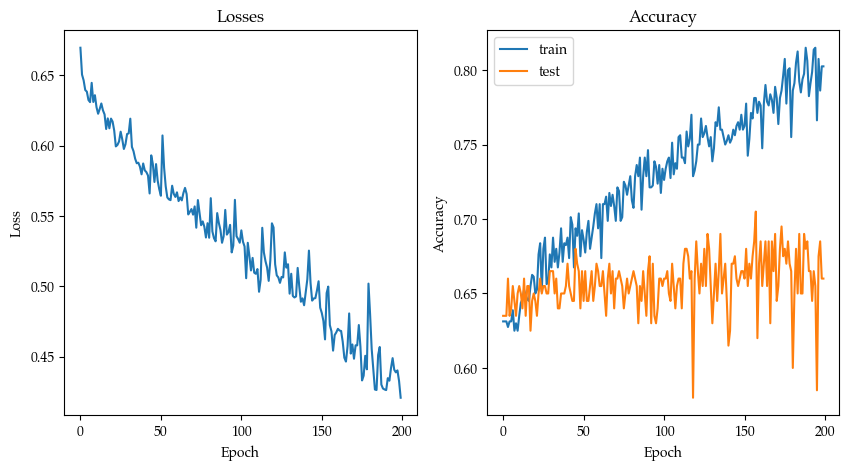

In [ ]:
exp.analyze()

In [ ]:
args['model'] = 'GCN_FP'
exp = TrainManager(dataloader, args)
exp.train(epochs=300, log=True)

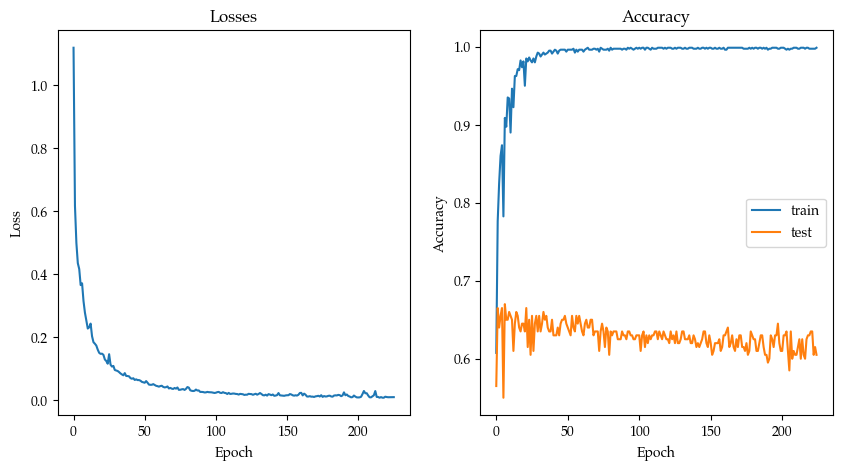

In [ ]:
exp.analyze()